# SSD - Single Shot Multibox Detector

Object detection is a task of finding (localizing, bounding box) one or more object/s, of interest from a given image.

Lots of techniques like [Faster RCNN](https://arxiv.org/abs/1506.01497), [YOLO](https://pjreddie.com/darknet/yolo/), [SSD](https://arxiv.org/abs/1512.02325) exists to solve the problem. In this notebook we will see an example of implementation of SSD using tensorflow and keras.

In [1]:
import keras, tensorflow, sys
keras.__version__, tensorflow.__version__, sys.version

Using TensorFlow backend.


('2.2.4',
 '1.11.0',
 '3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 11:27:44) [MSC v.1900 64 bit (AMD64)]')

Used for training on 1st GPU in a multi-GPU environment.

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

## Import packages

Import different packages for handling images and building the keras model.

In [3]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import re

from keras import backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler, TensorBoard, ModelCheckpoint
from keras.layers import Activation, concatenate, Flatten, Reshape
from keras.layers import BatchNormalization, Input, GlobalAveragePooling2D, ZeroPadding2D, MaxPooling2D, Conv2D
from keras import Model
from keras.models import load_model, model_from_json
from keras.optimizers import Adam, SGD
from keras.utils.np_utils import to_categorical
from keras.engine.topology import InputSpec
from keras.engine.topology import Layer


from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix,f1_score, precision_score, recall_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, StandardScaler

import random
import pickle
from datetime import datetime
from glob import glob 
import itertools
import json
from xml.etree import ElementTree
import cv2

# Pacakge for viewing the images
from matplotlib import pyplot as plt
%matplotlib inline


## Import Local packages

Import the functions from the python files. These files were taken from [https://github.com/oarriaga/SSD-keras/](https://github.com/oarriaga/SSD-keras/)

In [4]:
from data_generator import DataGenerator
from boxes import to_point_form, create_prior_boxes, unregress_boxes, apply_non_max_suppression

In [5]:
# Function to converte labels to one hot vectors.
def to_one_hot(class_name):
    one_hot_vector = [0] * len(class_names)
    class_arg = class_dict[class_name]
    one_hot_vector[class_arg] = 1
    return one_hot_vector

In [6]:
class Conv2DNormalization(Layer):
    """Normalization layer as described in ParseNet paper.
    # Arguments
        scale: Default feature scale.
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        Same as input
    # References
        http://cs.unc.edu/~wliu/papers/parsenet.pdf
    # TODO
        Add possibility to have one scale for all features.
    """
    def __init__(self, scale, **kwargs):
        self.axis = 3
        self.scale = scale
        super(Conv2DNormalization, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_spec = [InputSpec(shape=input_shape)]
        shape = (input_shape[self.axis],)
        init_gamma = self.scale * np.ones(shape)
        self.gamma = K.variable(init_gamma, name='{}_gamma'.format(self.name))
        self.trainable_weights = [self.gamma]

    def call(self, x, mask=None):
        output = K.l2_normalize(x, self.axis)
        output = output * self.gamma
        return output
    
    def get_config(self):
        config = {'scale': self.scale}

        base_config = super(Conv2DNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [7]:
# Concatenate all the different layers containing features from different scopes and also
# for both regression of boxes and classification of objects.

def add_ssd_modules(output_tensors, num_classes, num_priors,
                    with_batch_norm=True):

    classification_layers, regression_layers = [], []
    for layer_arg, base_layer in enumerate(output_tensors):

        str_arg = str(layer_arg)
        # classification leaf
        class_name = 'classification_leaf_' + str(layer_arg)
        class_leaf = Conv2D(num_priors[layer_arg] * num_classes, (3, 3),
                            padding='same', name=class_name)(base_layer)
        if with_batch_norm:
            class_leaf = BatchNormalization(
                    name='batch_norm_ssd_3_' + str_arg)(class_leaf)

        class_leaf = Flatten(name='flatten_ssd_1_' + str_arg)(class_leaf)
        classification_layers.append(class_leaf)

        # regression leaf
        regress_name = 'regression_leaf_' + str(layer_arg)
        regress_leaf = Conv2D(num_priors[layer_arg] * 4, (3, 3),
                              padding='same', name=regress_name)(base_layer)
        if with_batch_norm:
            regress_leaf = BatchNormalization(
                    name='batch_norm_ssd_4_' + str_arg)(regress_leaf)

        regress_leaf = Flatten(
                name='batch_norm_ssd_5_' + str_arg)(regress_leaf)
        regression_layers.append(regress_leaf)

    classifications = concatenate(classification_layers, axis=1)
    regressions = concatenate(regression_layers, axis=1)

    if hasattr(regressions, '_keras_shape'):
        num_boxes = regressions._keras_shape[-1] // 4
    elif hasattr(regressions, 'int_shape'):
        num_boxes = K.int_shape(regressions)[-1] // 4

    classifications = Reshape(
            (num_boxes, num_classes),
            name='reshape_new_ssd_1_' + str_arg)(classifications)

    classifications = Activation(
            'softmax', name='activation_ssd_1_' + str_arg)(classifications)

    regressions = Reshape((num_boxes, 4),
                          name='reshape_ssd_2_' + str_arg)(regressions)

    boxes_output = concatenate([regressions, classifications],
                               axis=2, name='predictions')
    return boxes_output

In [8]:
# Defining loss for both regression (for box cordinates) and multi class loss (label classifier) and combining them.

class MultiboxLoss(object):
    def __init__(self, num_classes, neg_pos_ratio=3,
                 alpha=1.0, background_id=0, max_num_negatives=300):
        self.num_classes = num_classes
        self.alpha = alpha
        self.neg_pos_ratio = neg_pos_ratio
        self.background_id = background_id
        self.max_num_negatives = max_num_negatives

    def smooth_l1(self, y_true, y_pred):
        absolute_value_loss = K.abs(y_true - y_pred) - 0.5
        square_loss = 0.5 * (y_true - y_pred)**2
        absolute_value_condition = K.less(absolute_value_loss, 1.0)
        l1_smooth_loss = tf.where(absolute_value_condition, square_loss,
                                  absolute_value_loss)
        return K.sum(l1_smooth_loss, axis=-1)

    def cross_entropy(self, y_true, y_pred):
        y_pred = K.maximum(K.minimum(y_pred, 1 - 1e-15), 1e-15)
        cross_entropy_loss = - K.sum(y_true * K.log(y_pred), axis=-1)
        return cross_entropy_loss

    def compute_loss(self, y_true, y_pred):
        class_loss = self.cross_entropy(y_true[:, :, 4:], y_pred[:, :, 4:])
        local_loss = self.smooth_l1(y_true[:, :, :4], y_pred[:, :, :4])
        negative_mask = y_true[:, :, 4 + self.background_id]
        positive_mask = 1 - negative_mask

        # calculating the positive loss per sample
        positive_local_losses = local_loss * positive_mask
        positive_class_losses = class_loss * positive_mask
        positive_class_loss = K.sum(positive_class_losses, axis=-1)
        positive_local_loss = K.sum(positive_local_losses, axis=-1)

        # obtaining the number of negatives in the batch per sample
        num_positives_per_sample = K.cast(K.sum(positive_mask, -1), 'int32')
        num_hard_negatives = self.neg_pos_ratio * num_positives_per_sample
        num_negatives_per_sample = K.minimum(num_hard_negatives,
                                             self.max_num_negatives)
        negative_class_losses = class_loss * negative_mask

        elements = (negative_class_losses, num_negatives_per_sample)
        negative_class_loss = tf.map_fn(
                lambda x: K.sum(tf.nn.top_k(x[0], x[1])[0]),
                elements, dtype=tf.float32)

        class_loss = positive_class_loss + negative_class_loss
        total_loss = class_loss + (self.alpha * positive_local_loss)

        # when the number of positives is zero set the total loss to zero
        batch_mask = K.not_equal(num_positives_per_sample, 0)
        total_loss = tf.where(batch_mask, total_loss, K.zeros_like(total_loss))

        # check for the case in which there are no positive boxes in a sample
        num_positives_per_sample = tf.where(
                batch_mask, num_positives_per_sample,
                K.ones_like(num_positives_per_sample))

        num_positives_per_sample = K.cast(num_positives_per_sample, 'float32')
        total_loss = total_loss / num_positives_per_sample
        return total_loss

In [9]:
# Learning rate Scheduler for training

def scheduler(epoch):
    if epoch < 250:
        return 0.001
    elif epoch < 400:
        return 0.0001
    else:
        return 0.00001

In [10]:
class_names = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
                       'bottle', 'bus', 'car', 'cat', 'chair', 'cow',
                       'diningtable', 'dog', 'horse', 'motorbike', 'person',
                       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

class_dict = {value: key for key, value in enumerate(class_names)}

## Dataset

The dataset for this notebook is taken from -> http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar . 

Data is loaded and processed. Each of the array of bounding box and corresponding label (one hot vector) for the image is saved as a dictionary with image location as the key.

In [11]:
split_file = "./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/" + "train" + ".txt"
filenames = []
for line in open(split_file):
    filename = line.strip() + ".xml"
    filenames.append(filename)

In [12]:
split_file = "./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/ImageSets/Main/" + "val" + ".txt"
filenames_val = []
for line in open(split_file):
    filename = line.strip() + ".xml"
    filenames_val.append(filename)

In [13]:
def load_anno(filenames):
    data = dict()
    for filename in filenames:
        filename_path = "./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/" + filename

        tree = ElementTree.parse(filename_path)
        root = tree.getroot()

        bounding_boxes = []
        one_hot_classes = []

        size_tree = root.find('size')
        width = float(size_tree.find('width').text)
        height = float(size_tree.find('height').text)

        for object_tree in root.findall('object'):

            class_name = object_tree.find('name').text

            if class_name in class_names:
                one_hot_class = to_one_hot(class_name)
                one_hot_classes.append(one_hot_class)

                for bounding_box in object_tree.iter('bndbox'):
                    xmin = float(bounding_box.find('xmin').text) / width
                    ymin = float(bounding_box.find('ymin').text) / height
                    xmax = float(bounding_box.find('xmax').text) / width
                    ymax = float(bounding_box.find('ymax').text) / height

                bounding_box = [xmin, ymin, xmax, ymax]
                bounding_boxes.append(bounding_box)

        if len(one_hot_classes) == 0:
            continue

        image_name = root.find('filename').text
        bounding_boxes = np.asarray(bounding_boxes)
        one_hot_classes = np.asarray(one_hot_classes)
        image_data = np.hstack((bounding_boxes, one_hot_classes))

        if len(bounding_boxes.shape) == 1:
            image_data = np.expand_dims(image_data, axis=0)


        data["./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/"+ image_name] = image_data
    return data

In [14]:
train_data = load_anno(filenames)
val_data = load_anno(filenames_val)

## Sample Data point

In [15]:
random.sample(list(train_data.keys()), 1), random.sample(list(train_data.values()), 1)

(['./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/002350.jpg'],
 [array([[0.0437018 , 0.14375   , 0.77634961, 0.97083333, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 1.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.24164524, 0.14583333, 0.6066838 , 0.57916667, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 1.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.52442159, 0.6       , 0.76606684, 0.85416667, 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.    

## SSD Model

We take the [VGG16](https://arxiv.org/abs/1409.1556) model as the base model for extracting features. The weights for the VGG16 can be downloaded from [here](https://drive.google.com/file/d/0Bz7KyqmuGsilT0J5dmRCM0ROVHc/view?usp=sharing). 

In SSD features from different layers of network are taken to recognize different sizes of objects. Conceptually, shallow layers will be beter for recogninzing smaller objects and larger objects should be easy to recgnize from features of deeper layers. Therefore, features from 4 different layers of VGG16 model are taken and bounding box, labels are found in each of the featuresets. Unlike RCNN, in SSD, the model is meant to determine what object, rather than simply deteremining if there is an object in that part of an image or not.

Similar to anchor boxes in RCNN, SSD also uses the concept of prior boxes. These boxes are fixed size boxes, of different ratios meant for commonly occuring shapes. Eg. a standing man will most probably have a long rectangular bounding box. Prior boxes are meant for simplifying the neural networks job. In each point of the image now instead of many random objects, 4 prior boxes are drawn and only for these four boxes the model determines the object and exact bounding boxes. 

As you can see most of the points won't have presence of object, which leads to bias in the dataset for the training. For this reason only 3 boxes containing no objects are considered per box containing an object. Also amx suppression of boxes are done to get non-overlapping boxes. 

This is a very small description of SSD and if you want to understand the architecture better you can have a look at this [blog](https://medium.com/@jonathan_hui/ssd-object-detection-single-shot-multibox-detector-for-real-time-processing-9bd8deac0e06).

In [16]:
input_shape=(300, 300, 3)
num_classes=len(class_dict)
num_priors=[4, 6, 6, 6, 4, 4]
        

image = Input(shape=input_shape)

# Block 1 -----------------------------------------------------------------
conv1_1 = Conv2D(64, (3, 3), padding='same', activation='relu')(image)
conv1_2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv1_1)
pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                     padding='same', )(conv1_2)

# Block 2 -----------------------------------------------------------------
conv2_1 = Conv2D(128, (3, 3), padding='same', activation='relu')(pool1)
conv2_2 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv2_1)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                     padding='same')(conv2_2)

# Block 3 -----------------------------------------------------------------
conv3_1 = Conv2D(256, (3, 3), padding='same', activation='relu')(pool2)
conv3_2 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv3_1)
conv3_3 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv3_2)
pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                     padding='same')(conv3_3)

# Block 4 -----------------------------------------------------------------
conv4_1 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool3)
conv4_2 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv4_1)
conv4_3 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv4_2)

#conv4_3_norm = BatchNormalization(axis=3, name='branch_1')(conv4_3)
pool4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
                     padding='same')(conv4_3)

# Block 5 -----------------------------------------------------------------
conv5_1 = Conv2D(512, (3, 3), padding='same', activation='relu')(pool4)
conv5_2 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv5_1)
conv5_3 = Conv2D(512, (3, 3), padding='same', activation='relu')(conv5_2)
pool5 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1),
                     padding='same')(conv5_3)


conv4_3_norm = Conv2DNormalization(20, name='branch_1')(conv4_3)

# Dense 6/7 ------------------------------------------
pool5z = ZeroPadding2D(padding=(6, 6))(pool5)
fc6 = Conv2D(1024, (3, 3), dilation_rate=(6, 6), padding='valid',
             activation='relu')(pool5z)
fc7 = Conv2D(1024, (1, 1), padding='same', activation='relu',
             name='branch_2')(fc6)

# EXTRA layers in SSD -----------------------------------------------------
# Block 6 -----------------------------------------------------------------
conv6_1 = Conv2D(256, (1, 1), padding='same', activation='relu')(fc7)
conv6_1z = ZeroPadding2D()(conv6_1)
conv6_2 = Conv2D(512, (3, 3), strides=(2, 2), padding='valid',
                 activation='relu', name='branch_3')(conv6_1z)

# Block 7 -----------------------------------------------------------------
conv7_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv6_2)
conv7_1z = ZeroPadding2D()(conv7_1)
conv7_2 = Conv2D(256, (3, 3), padding='valid', strides=(2, 2),
                 activation='relu', name='branch_4')(conv7_1z)

# Block 8 -----------------------------------------------------------------
conv8_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv7_2)
conv8_2 = Conv2D(256, (3, 3), padding='valid', strides=(1, 1),
                 activation='relu', name='branch_5')(conv8_1)

# Block 9 -----------------------------------------------------------------
conv9_1 = Conv2D(128, (1, 1), padding='same', activation='relu')(conv8_2)
conv9_2 = Conv2D(256, (3, 3), padding='valid', strides=(1, 1),
                 activation='relu', name='branch_6')(conv9_1)

ssd_tenors = [conv4_3_norm, fc7, conv6_2, conv7_2, conv8_2, conv9_2]
output_tensor = add_ssd_modules(
        ssd_tenors, num_classes, num_priors, with_batch_norm=False)

model = Model(inputs=image, outputs=output_tensor)

In [19]:

# hyper-parameters
batch_size = 2
num_epochs = 250
alpha_loss = 1.0
learning_rate = 1e-3
momentum = .9
weight_decay = 5e-4
gamma_decay = 0.1
# scheduled_epochs = [155, 195, 235]
negative_positive_ratio = 3


prior_boxes = to_point_form(create_prior_boxes())

multibox_loss = MultiboxLoss(num_classes, negative_positive_ratio, alpha_loss)

optimizer = SGD(learning_rate, momentum, weight_decay)

model.compile(optimizer, loss=multibox_loss.compute_loss)

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 300, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 300, 300, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 150, 150, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [18]:
model.load_weights("./VGG16_weights.h5", by_name=True)

In [29]:
batch_size = 8
data_generator = DataGenerator(
        train_data, prior_boxes, batch_size, num_classes, val_data)

learning_rate_schedule = LearningRateScheduler(scheduler, verbose=0)

tb = TensorBoard(log_dir='./logs/ssd_VGG', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=True, write_images=True,
                 embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)


callbacks = [tb, ModelCheckpoint('./weights/ssd_VGG-{epoch:02d}_loss-{loss:.4f}_val_loss-{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=0,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)]


model.fit_generator(data_generator.flow(mode='train'),
                    steps_per_epoch=int(len(train_data) / batch_size),
                    epochs=num_epochs,
                    verbose=0,
                    callbacks=callbacks,
                    validation_data=data_generator.flow(mode='val'),
                    validation_steps=int(len(val_data) / batch_size),
                    use_multiprocessing=False,
                    workers=1)
                  

In [30]:
# serialize weights to HDF5
model.save_weights("ssd_model.h5")
print("Saved model to disk")



Saved model to disk


In [31]:
def substract_mean(image_array):
    R_MEAN = 123
    G_MEAN = 117
    B_MEAN = 104
    
    image_array = image_array.astype(np.float32)
    image_array[:, :, 0] -= R_MEAN
    image_array[:, :, 1] -= G_MEAN
    image_array[:, :, 2] -= B_MEAN
    image_array = image_array[:, :, ::-1]
    return image_array

In [32]:
def detect(box_data, prior_boxes, conf_thresh=0.01, nms_thresh=.45,
           top_k=200, variances=[.1, .1, .2, .2]):

    box_data = np.squeeze(box_data)
    regressed_boxes = box_data[:, :4]
    class_predictions = box_data[:, 4:]
    unregressed_boxes = unregress_boxes(regressed_boxes,
                                        prior_boxes, variances)

    num_classes = class_predictions.shape[1]
    output = np.zeros((1, num_classes, top_k, 5))
    for class_arg in range(1, num_classes):
        conf_mask = class_predictions[:, class_arg] >= (conf_thresh)
        scores = class_predictions[:, class_arg][conf_mask]
        if len(scores) == 0:
            continue
        boxes = unregressed_boxes[conf_mask]
        indices, count = apply_non_max_suppression(boxes, scores,
                                                   nms_thresh, top_k)
        scores = np.expand_dims(scores, -1)
        selections = np.concatenate((scores[indices[:count]],
                                    boxes[indices[:count]]), axis=1)

        output[0, class_arg, :count, :] = selections
    return output


## Sample Predictions

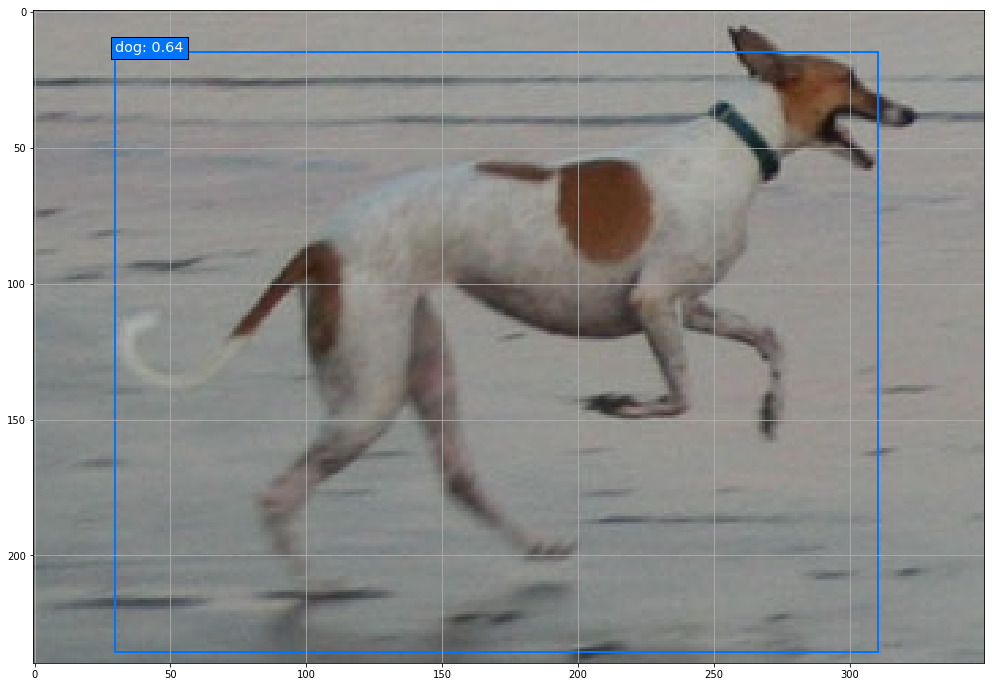

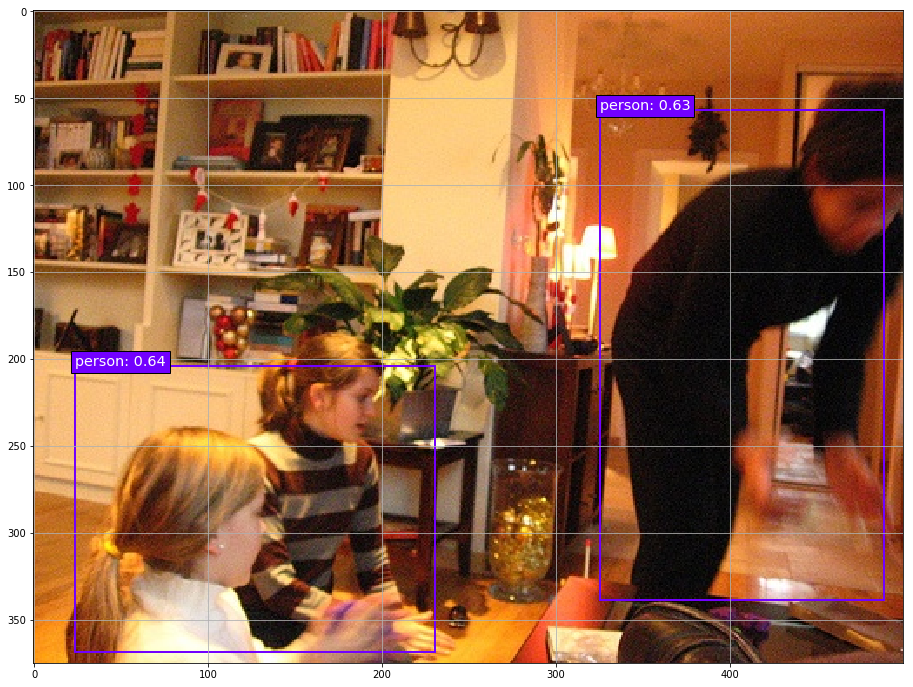

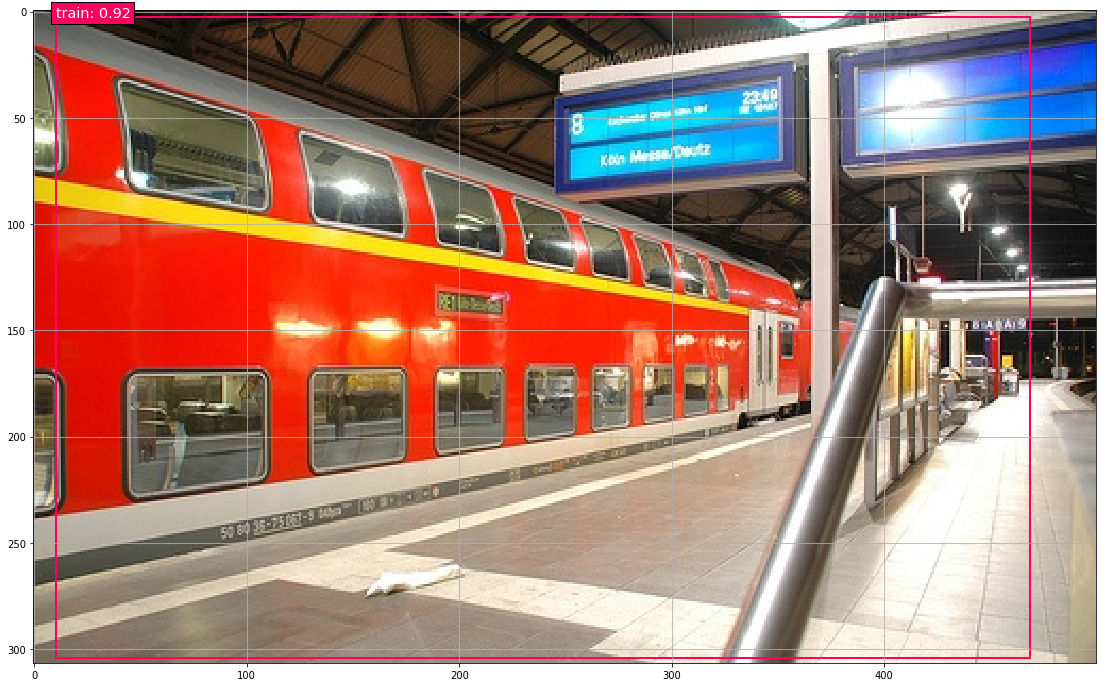

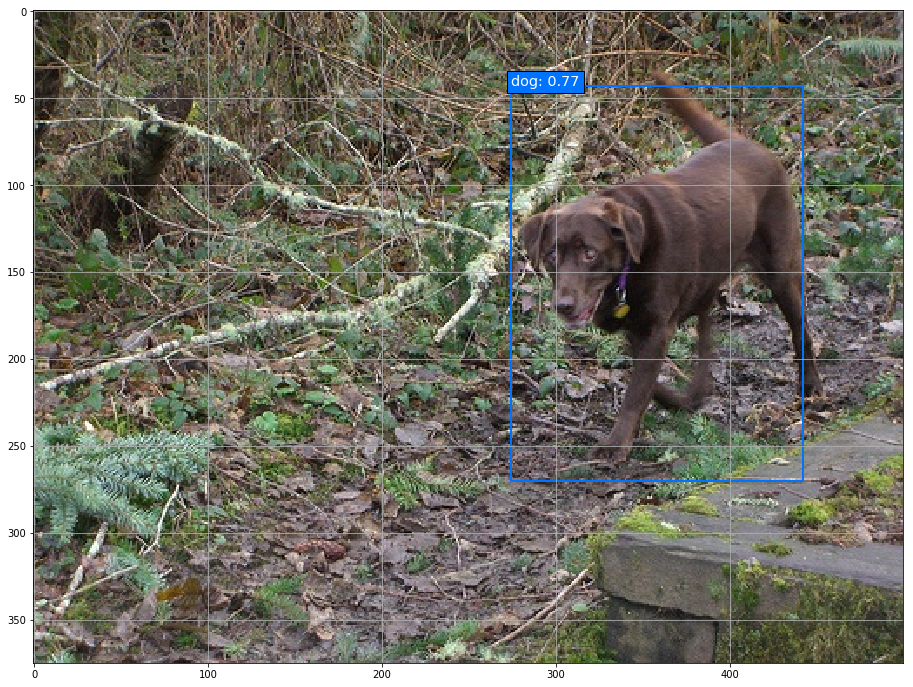

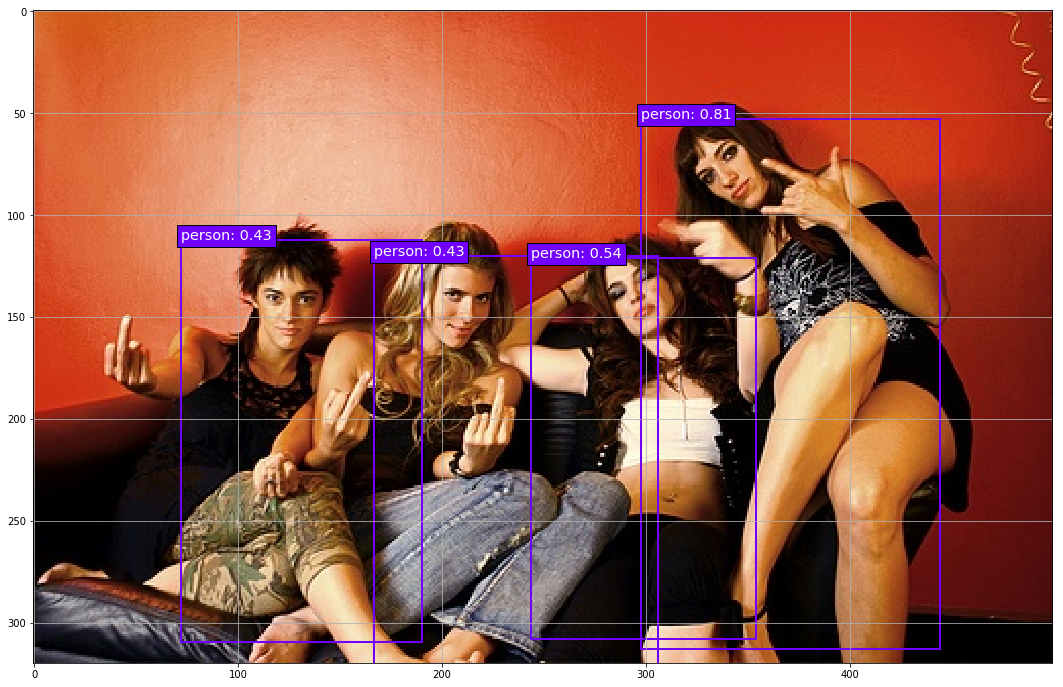

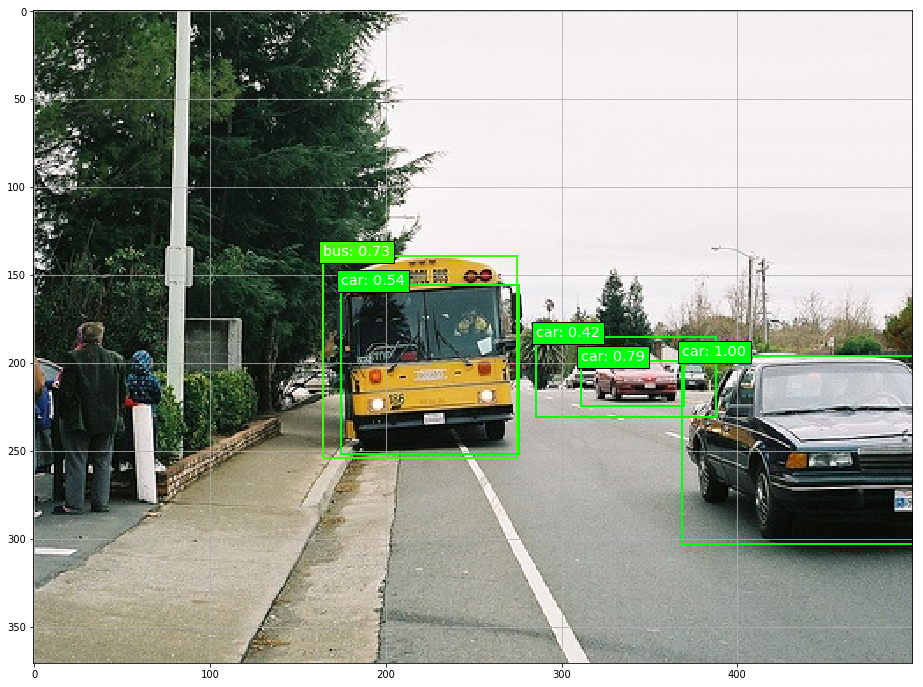

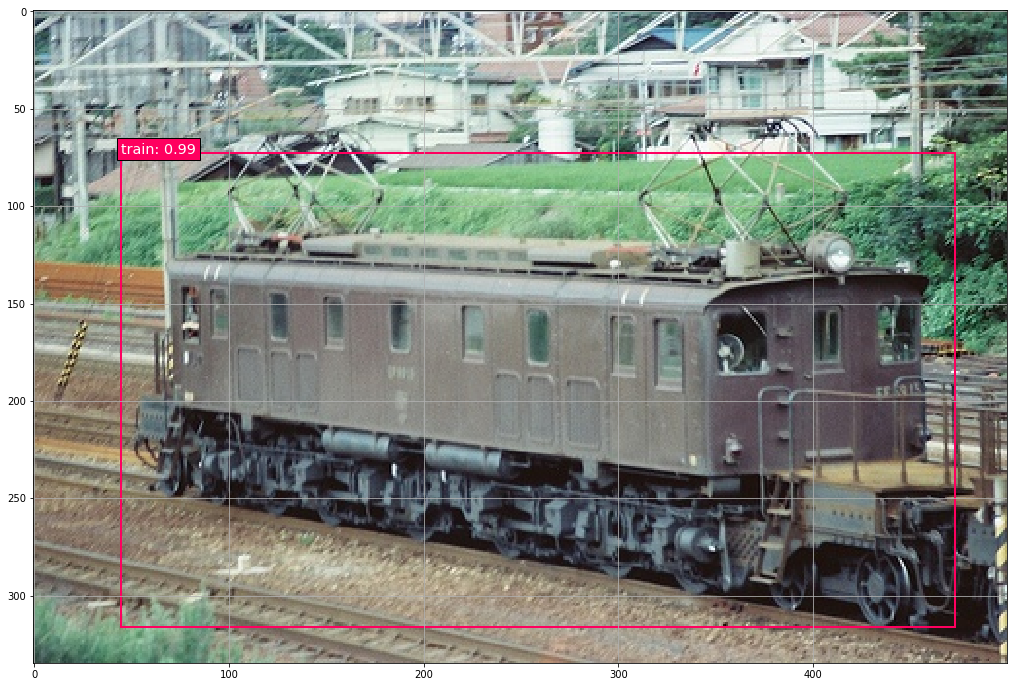

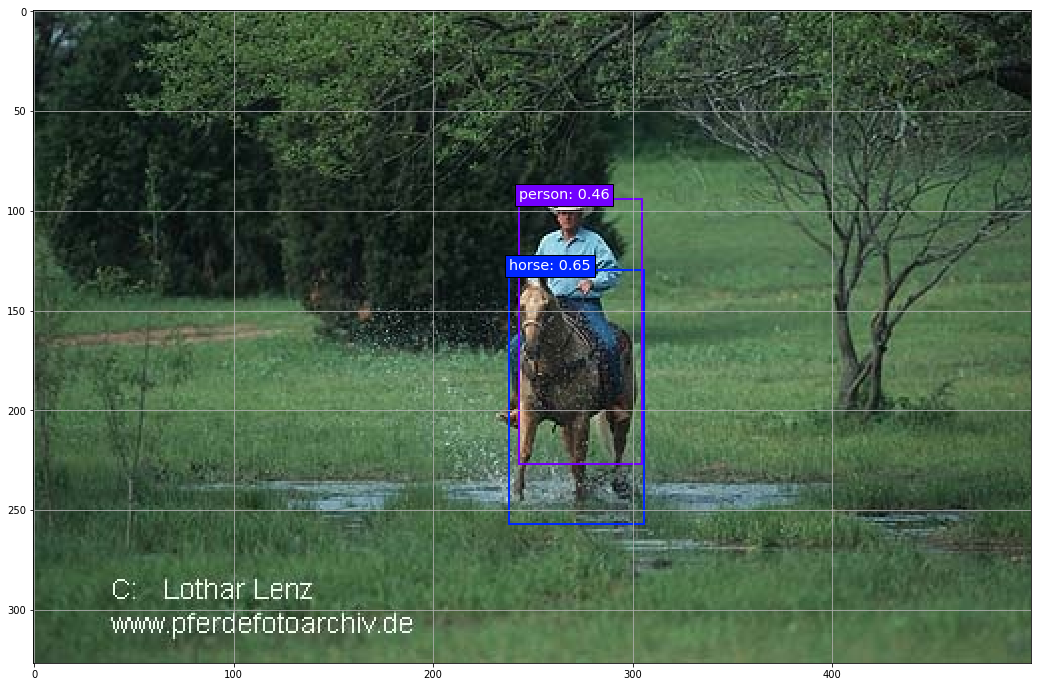

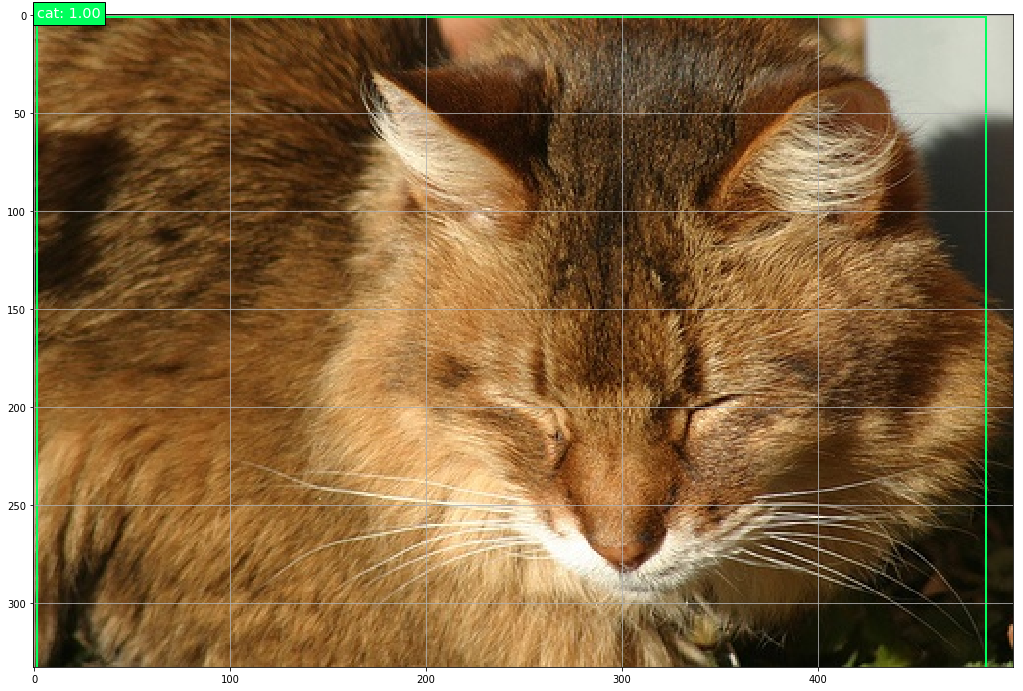

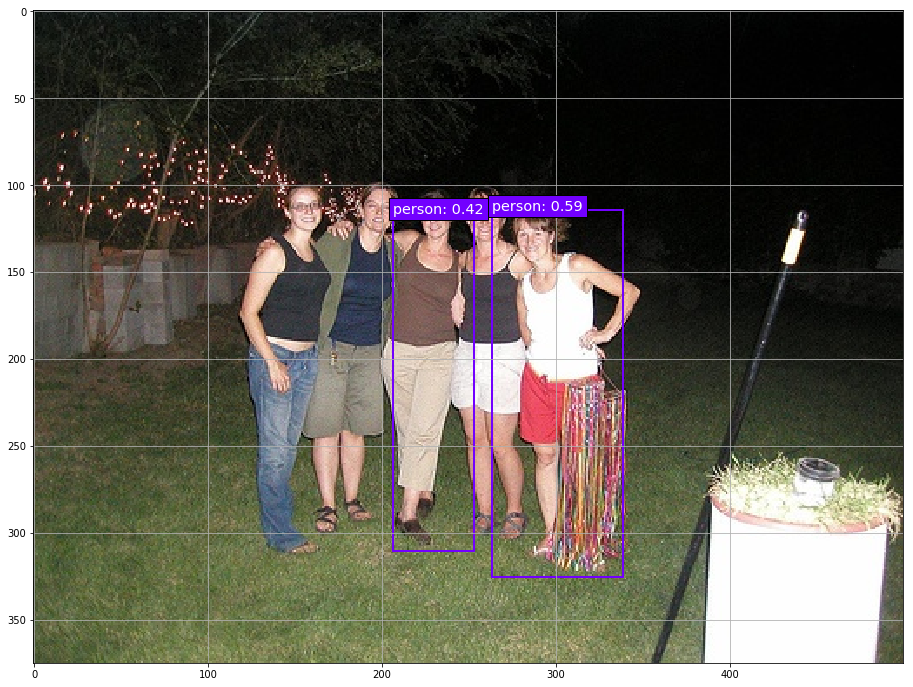

In [42]:


confidence_threshold = 0.4

image_test = "./VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/JPEGImages/*.jpg"
image_test = glob(image_test)
image_test = random.sample(image_test, 10)
for image in image_test:
    orig_image = cv2.imread(image)
    orig_image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB)
    
    image = cv2.resize(orig_image, (300, 300))
    image = substract_mean(image)
    image = np.expand_dims(image, 0)
    
    pred = model.predict(image)
    pred = detect(pred, prior_boxes)
    pred = pred[0]
    
    # Display the image and draw the predicted boxes onto it.

    # Set the colors for the bounding boxes
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat',
               'chair', 'cow', 'diningtable', 'dog',
               'horse', 'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

    plt.figure(figsize=(20,12))
    plt.grid(),plt.subplot(111),plt.imshow(orig_image)
    
    current_axis = plt.gca()

    for c in range(1, 21):
        for box in pred[c]:
            if box[0]>confidence_threshold:
                # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
                xmin = box[1] * orig_image.shape[1] 
                ymin = box[2] * orig_image.shape[0] 
                xmax = box[3] * orig_image.shape[1] 
                ymax = box[4] * orig_image.shape[0] 

                color = colors[c]

                label = '{}: {:.2f}'.format(classes[c], box[0])

                current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2)) 

                current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})
    plt.show()